In [4]:
import sys

sys.path.append('/home/radlr/anaconda3/envs/lVGPU2/lib/python3.6/site-packages')

In [5]:
# math etc.
from scipy import misc
import numpy as np

#plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

#image functions, esp. resizing
import cv2
#directory functions
import os

In [ ]:
def cuttleVision(cSpher,fN,nStk,off,defAtt):
    img = 1.0*misc.imread(fN)
    sBNarrower = 1.0*misc.imread('./sBandiensisNarrower-1.tif')
    sBNarrow = 1.0*misc.imread('./sBandiensisNarrow-1.tif')
    sBFull = 1.0*misc.imread('./sBandiensisFuller-1.tif')
    
    dimX = np.shape(sBNarrower)[0]
    mid = dimX/2
    dimImg = np.shape(img)[0]
    
    N = 12.5 #25mm eye
    x1, y1 = np.meshgrid(np.arange(-N,N-N/dimX,2*N/dimX),np.arange(-N,N-N/dimX,2*N/dimX))
    
    rad = np.sqrt(x1**2+y1**2)
    
    apDef = np.exp(np.sqrt(3)*(2*rad**2-1))
    apSpher = np.exp(np.sqrt(5) * (6*rad**4 - 6*rad**2+1))
    
    nStk = 2 # three focus depths
    
    
    imgStack = np.zeros([dimImg,dimImg,3])
    
    myPSFDim = 48
    PSF = np.zeros([myPSFDim*2,myPSFDim*2,9])
    
    for c in range(0,nStk+1):
        
        cChromR = 1 - (c / (nStk))
        cChromB = 1.0 - cChromR
        cChromG = 0.5 - cChromR
        if (0):
            apR1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        if(1):
            apR1 = (sBFull) * np.exp(1j*2*np.pi*(cChromR/defAtt*apDef+cSpher*apSpher));
            apG1 = (sBFull) * np.exp(1j*2*np.pi*(cChromG/defAtt*apDef+cSpher*apSpher));
            apB1 = (sBFull) * np.exp(1j*2*np.pi*(cChromB/defAtt*apDef+cSpher*apSpher));
        
        apR1 = np.nan_to_num(apR1)
        apG1 = np.nan_to_num(apG1)
        apB1 = np.nan_to_num(apB1)
                
        PSF1R = np.abs(np.fft.fft2(apR1))**2
        PSF1G = np.abs(np.fft.fft2(apG1))**2
        PSF1B = np.abs(np.fft.fft2(apB1))**2
        
        #normalize PSFs
        if (0):
            PSF1R = PSF1R/np.max(np.max(PSF1R)); #%abs(fft(apR1)).^2;
            PSF1G = PSF1G/np.max(np.max(PSF1G));
            PSF1B = PSF1B/np.max(np.max(PSF1B));
        
        tempR = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,0],[dimX,dimX])*np.fft.fft2(PSF1R)))
        tempG = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,1],[dimX,dimX])*np.fft.fft2(PSF1G)))
        tempB = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,2],[dimX,dimX])*np.fft.fft2(PSF1B)))
        
        tempR = (tempR - np.min(tempR)) / np.max(tempR)
        tempG = (tempG - np.min(tempG)) / np.max(tempG)
        tempB = (tempB - np.min(tempB)) / np.max(tempB)
        
        tempR = tempR[0:dimImg,0:dimImg]
        tempG = tempG[0:dimImg,0:dimImg]
        tempB = tempB[0:dimImg,0:dimImg]
        
        myPSFDim = 48
        PSF1R = np.fft.fftshift(PSF1R)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1G = np.fft.fftshift(PSF1G)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1B = np.fft.fftshift(PSF1B)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        
        imgStack[:,:,c] = tempR + tempG + tempB
        if(0):
            imgStack[:,:,c*3+0] = tempR
            imgStack[:,:,c*3+1] = tempG
            imgStack[:,:,c*3+2] = tempB
        if(1):
            PSF[:,:,c*3+0] = PSF1R
            PSF[:,:,c*3+1] = PSF1G
            PSF[:,:,c*3+2] = PSF1B
        if (0): #plot for debugging/testing defocus parameters
            plt.figure(figsize=(12,12))
            plt.subplot(321)
            plt.imshow(tempR,cmap='gray')
            plt.subplot(322)
            plt.imshow(tempG,cmap='gray')
            plt.subplot(323)
            plt.imshow(tempB,cmap='gray')
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
            myImgRGB = np.zeros([dimImg,dimImg,3])
            myImgRGB[:,:,0] = tempR
            myImgRGB[:,:,1] = tempG
            myImgRGB[:,:,2] = tempB
            plt.figure(figsize=(6,6))
            plt.imshow(myImgRGB)
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
    return imgStack, PSF

In [ ]:
#Generate random RGB images

myDimSm = 16
myDimFl = 64
simgStkNo = 1024

#make it deterministic
np.random.seed(1)
simgStk = np.zeros([simgStkNo,myDimSm,myDimSm,3])
for c in range(0,simgStkNo):
    myTestR = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTestG = 255*( np.random.random([myDimSm,myDimSm]) < 0.125)
    myTestB = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTest =np.zeros([myDimSm,myDimSm,3])
    myTest[:,:,0] = myTestR
    myTest[:,:,1] = myTestG
    myTest[:,:,2] = myTestB
    myTest = myTest*255
    simgStk[c] = myTest
    if(c % 500 == 0):

        plt.figure()

        plt.imshow(myTest)

        plt.colorbar()
        plt.show()

    
print(np.shape(simgStk))


In [ ]:
#Resize and store simulated RGB images

simgStkFl = np.zeros([simgStkNo,myDimFl,myDimFl,3])
for c in range(0,simgStkNo):
    myImg = simgStk[c]
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
    myImg = myImg[0:myDim,0:myDim,:]
    myResImg = cv2.resize(myImg,(myDimFl,myDimFl), interpolation = cv2.INTER_CUBIC)
    simgStkFl[c] = myResImg
    cv2.imwrite('./sImgs/simulatedImg'+str(c)+'.tif',myResImg)
    if(c % 500 == 0):

        plt.figure()

        plt.subplot(121)
        plt.imshow(simgStk[c])
        plt.subplot(122) 
        plt.imshow(myResImg)
        #plt.colorbar()
        plt.show()

In [ ]:
#shape of the full image stack
print(np.shape(simgStkFl))

In [ ]:
# The full-size simulated RGB image stack is the training target
# now to create an input stack using the cuttleVision function

myMiniDir = os.listdir('./sImgs/')
cSpher = 0
nStk = 3
off = 0
defAtt = 9e3
myTargets = []
myImgs = []

#note cv2 to color function for displaying RGB images
#opencv store images as BGR instead of RGB, so we have to fix it
#cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB)
myC = 0 
for k in myMiniDir:
    myC = myC+1 
    #myImg = cv2.imread('./sImgs/' + str(c))
    print(k)
    #Compute cuttlevision
    imgStk, PSFStk = cuttleVision(cSpher,'./sImgs/'+str(k),nStk,off,defAtt)
    #Load target image
    myImg = cv2.imread('./sImgs/'+str(k))
    myImgs.append(imgStk)
    myTargets.append(myImg)
    
    if (( myC % 250)==0):
        myFig, myAxes = plt.subplots(1,3,figsize=(10,10))
        for c in range(0,4):
            #for x in range(0,3):
            #plt.subplot(3,3,c+1)
            if(c < 3):
                myAxes[c].imshow(imgStk[:,:,c],cmap="gray")
                myAxes[c].set_xticklabels([])
                myAxes[c].set_yticklabels([])
            else:
                plt.figure()
                plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
                #myAxes[c].set_xticklabels([])
                #myAxes[c].set_yticklabels([])
            #plt.tight_layout()
        
    
    plt.show()
    
print("Target vector shape: ", np.shape(myTargets))
print("Training vector shape: ", np.shape(myImgs))
            
        
                                           

In [ ]:
%store myImgs
%store myTargets
print("Targets and training stored")

In [3]:
%store -r myImgs
%store -r myTargets
print(np.shape(myImgs))
print(np.shape(myTargets))
myImgs = np.array(myImgs)
myTargets = np.array(myTargets)

trainWide = np.zeros([np.shape(myImgs)[0],np.shape(myImgs)[1],np.shape(myImgs)[2]*3])
targetWide = np.zeros([np.shape(myImgs)[0],np.shape(myImgs)[1],np.shape(myImgs)[2]*3])

numSamples = 1024
print(np.shape(trainWide), ' ', np.shape(targetWide))

trainWide = np.reshape(myImgs,[numSamples,64*64*3],'F')

targetWide = np.reshape(myTargets,[numSamples,64*64*3],'F')
print(np.shape(trainWide.T))
if(0):
    plt.figure()
    plt.imshow(trainWide[500,:],cmap='gray')
    plt.show()
    plt.figure()
    plt.subplot(131)
    plt.imshow(myImgs[500,:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(myImgs[500,:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(myImgs[500,:,:,2],cmap='gray')
    plt.show()

(1024, 64, 64, 3)
(1024, 64, 64, 3)
(1024, 64, 192)   (1024, 64, 192)
(12288, 1024)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 259969.0


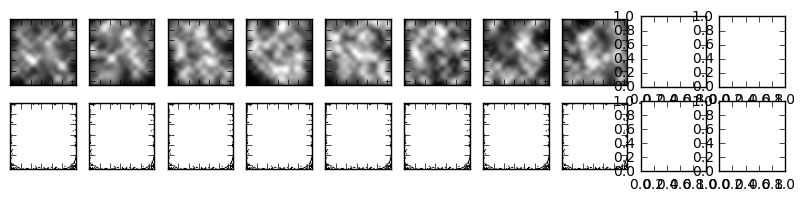

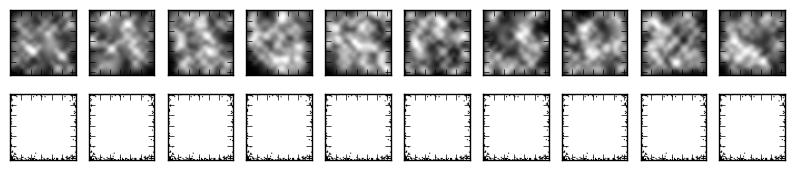

In [99]:
"""Following along from Siraj: https://github.com/llSourcell/autoencoder_demo/blob/master/main.py"""
import tensorflow as tf


imgWidth = 64
imgHeight = 64
n_visible = imgWidth *imgHeight
n_hidden = 2384

corruption_level = 0.3

# create node for input data and corruption mask
X = tf.placeholder("float",[None, n_visible], name='X')
mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
W_init = tf.random_uniform(shape=[n_visible,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]),name='b')

w_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')

def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask*X #corrupt version
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z

Z = model(X, mask, W, b, w_prime, b_prime)

cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])

dispIt = 200 # display every th iteration

with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(1):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {X: input_, mask: mask_np})
        mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( i % dispIt == 0):
            print(i,sess.run(cost, feed_dict={X: teX, mask: mask_np}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(Z,feed_dict = {X: test_xs, mask: mask_np})
            #print(recon.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (64,64)),cmap="gray")
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (64,64)),cmap="gray")
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()


    

In [49]:
xTestVis = tf.cast(teX[0:128,:],tf.float32)
print(np.shape(xTestVis))
mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
yPred = model(xTestVis,mask_np,W,b,w_prime,b_prime)
#yPred = np.array([yPred[0]])
print(np.shape(yPred))
#yPredImg = np.reshape(yPred,[64,64])

#yTrueImg = np.reshape(yTrue,[64,64])
test_xs = xTestVis
recon = yPred
fig, axs = plt.subplots(2, 2, figsize=(6, 3))
print(np.shape(test_xs[0]))


for example_i in range(1):
    #print(example_i)
    axs[0][example_i].imshow(
        np.reshape(test_xs, (64, 64)))
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i], (12288,)) + mean_img,
            (64, 64)))

plt.figure()
plt.subplot(121)
plt.imshow(yPredImg)
plt.subplot(122)
plt.imshow(yPredImg)
plt.show()

(128, 4096)
(128, 4096)
(4096,)


ValueError: cannot reshape array of size 1 into shape (64,64)